Team Name: Pathfinder \
Team Member: Vignesh S S\
Problem Statememnt: AI-Based Computer Vision for Healthcare Hackathon\
Dataset Link: https://drive.google.com/drive/u/1/folders/1UVvAea975DxWIYFSULqmqVMKLquBOs1Y \

**Attention U-net is used for segmentation** - This is Hypothesis-2

In [1]:
#!pip install gdown
#!gdown --folder 1UVvAea975DxWIYFSULqmqVMKLquBOs1Y  --remaining-ok

Hypothesis -1 : Just Unet based segmentation model

In [2]:
# Install the library for segmentation models
!pip install -U torchmetrics albumentations segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.5 MB/s eta 0:00:00


In [6]:
from google.colab import drive
import os

# Mount your Google Drive at /content/drive
drive.mount('/content/drive')

# --- Configuration ---
# IMPORTANT: Change this to the exact name of your zip file in Google Drive
ZIP_FILE_NAME = "/Hackathon_Dataset_20251025T071740Z.zip"
ZIP_PATH_ON_DRIVE = f"/content/{ZIP_FILE_NAME}"
UNZIP_DESTINATION = "/content/"  # Unzips to the fast local /content/ disk

# --- Unzip Logic ---
if os.path.exists(ZIP_PATH_ON_DRIVE):
    print(f"Found zip file at: {ZIP_PATH_ON_DRIVE}")
    print("Unzipping to local disk... This may take a minute.")
    # -q (quiet) suppresses the long list of all 200+ files
    !unzip -q "{ZIP_PATH_ON_DRIVE}" -d "{UNZIP_DESTINATION}"
    print("Unzipping complete!")

    # Verify the expected folder is now present
    print("Contents of /content/ (your unzipped data):")
    !ls "/content/"
else:
    print(f"ERROR: Zip file not found at: {ZIP_PATH_ON_DRIVE}")
    print("Please check the file name and its location in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found zip file at: /content//Hackathon_Dataset_20251025T071740Z.zip
Unzipping to local disk... This may take a minute.
Unzipping complete!
Contents of /content/ (your unzipped data):
 drive		      Hackathon_Dataset_20251025T071740Z.zip
'Hackathon Dataset'   sample_data


In [4]:
# --- 1. Imports ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Import the learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import cv2  # OpenCV for image processing
import numpy as np
import os
import glob  # For finding files
from tqdm.notebook import tqdm  # For progress bars
import albumentations as A
import segmentation_models_pytorch as smp
import torchmetrics  # For IoU/Jaccard metric

In [7]:
# --- 2. Helper Function: Letterbox Padding ---

def letterbox_image(image, mask, target_size=(384, 384)):
    """
    Resizes and pads an image and its mask to a target square size
    while maintaining the original aspect ratio.

    Args:
        image (np.array): The input image (H, W).
        mask (np.array): The corresponding segmentation mask (H, W).
        target_size (tuple): The desired output size (height, width).

    Returns:
        tuple: A tuple (padded_image, padded_mask).
    """
    h, w = image.shape[:2]  # Original height, width

    # Calculate scale factor to fit the longest side
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Use INTER_LINEAR for resizing the image (good quality)
    resized_image = cv2.resize(
        image, (new_w, new_h), interpolation=cv2.INTER_LINEAR
    )

    # Use INTER_NEAREST for the mask. This is CRITICAL.
    # It prevents creating new class values (e.g., 0.5) during resize.
    resized_mask = cv2.resize(
        mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST
    )

    # Calculate padding for top/bottom and left/right
    top = (target_size[0] - new_h) // 2
    bottom = target_size[0] - new_h - top
    left = (target_size[1] - new_w) // 2
    right = target_size[1] - new_w - left

    # Pad the image with black (value=0)
    padded_image = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )

    # Pad the mask with the background class (value=0)
    padded_mask = cv2.copyMakeBorder(
        resized_mask, top, bottom, left, right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )
    return padded_image, padded_mask


# --- 3. Custom PyTorch Dataset Class ---

class FetalHeartDataset(Dataset):
    """
    Custom Dataset for loading fetal heart ultrasound images and
    dynamically creating segmentation masks from ellipse .txt files.
    """
    def __init__(self, image_paths, label_paths, target_size=(384, 384),
                 augmentations=None):
        """
        Args:
            image_paths (list[str]): List of file paths to the images.
            label_paths (list[str]): List of file paths to the .txt labels.
            target_size (tuple): The target size for letterbox padding.
            augmentations (A.Compose, optional): Albumentations pipeline.
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.target_size = target_size
        self.augmentations = augmentations
        # Map class names to integer values for the mask
        self.class_map = {"cardiac": 1, "thorax": 2}  # 0 is background

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def create_mask_from_txt(self, label_path, img_shape):
        """Generates a 3-class mask from ellipse coordinates in a .txt file."""
        # Start with a black mask (all zeros = background class)
        mask = np.zeros(img_shape, dtype=np.uint8)
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 6:
                        continue  # Skip malformed lines

                    # Parse data from the line
                    center_x = float(parts[0])
                    center_y = float(parts[1])
                    # cv2.ellipse expects radius (half of the axis)
                    major_axis = float(parts[2]) / 2
                    minor_axis = float(parts[3]) / 2
                    angle = float(parts[4])
                    class_name = parts[5]

                    class_value = self.class_map.get(class_name)
                    if class_value is not None:
                        # Draw the filled ellipse on the mask
                        cv2.ellipse(
                            img=mask,
                            center=(int(center_x), int(center_y)),
                            axes=(int(major_axis), int(minor_axis)),
                            angle=angle,
                            startAngle=0,
                            endAngle=360,
                            color=class_value,
                            thickness=-1  # -1 means filled
                        )
        except Exception as e:
            print(f"Error processing mask file {label_path}: {e}")
        return mask

    def __getitem__(self, idx):
        """
        Fetches one sample (image, mask) from the dataset, processes it,
        and returns it as a PyTorch Tensor.
        """
        # Load image as grayscale
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise IOError(f"Could not read image: {img_path}")

        # Create corresponding mask
        label_path = self.label_paths[idx]
        mask = self.create_mask_from_txt(label_path, image.shape[:2])

        # Apply letterbox padding to maintain aspect ratio
        image, mask = letterbox_image(image, mask, self.target_size)

        # Apply augmentations (if any are provided)
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to PyTorch tensors
        # Add channel dimension: (H, W) -> (1, H, W)
        image = torch.from_numpy(image).float().unsqueeze(0)
        # Mask should be LongTensor, no channel dim: (H, W)
        mask = torch.from_numpy(mask).long()

        # Normalize image to [0, 1]
        image = image / 255.0

        return image, mask


# --- 4. Define Augmentation Pipelines ---
# We are adding more aggressive augs to match the video
train_augs = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7,
                       border_mode=cv2.BORDER_CONSTANT, value=0),
    A.ElasticTransform(p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),

    # --- NEW AUGMENTATIONS TO FIX DOMAIN SHIFT ---
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), # More intense
    A.GaussNoise(var_limit=(10.0, 70.0), p=0.8), # More intense
    A.RandomGamma(gamma_limit=(80, 120), p=0.5), # New
    A.MotionBlur(p=0.3),
])

# No augmentations for the validation set, just padding (handled by Dataset)
val_augs = None

# --- 5. Set Up Paths and DataLoaders (CORRECTED) ---

# Base path where the dataset was unzipped
BASE_DATA_PATH = "/content/Hackathon Dataset/"

# --- Define dataset-specific paths ---
TRAIN_DIR = os.path.join(BASE_DATA_PATH, "Images/training")
VAL_DIR = os.path.join(BASE_DATA_PATH, "Images/validation")

# --- Find all image and label files ---

# Get Training paths
# 1. Find all image files
train_img_paths = sorted(glob.glob(os.path.join(TRAIN_DIR, "images", "*.png")))
# 2. Create label paths *based on* the image paths
train_lbl_paths = [
    p.replace("/images/", "/annfiles_ellipse/")  # Swap folder name
     .replace(".png", ".txt")                   # Swap extension
    for p in train_img_paths
]

# Get Validation paths
# 1. Find all image files
val_img_paths = sorted(glob.glob(os.path.join(VAL_DIR, "images", "*.png")))
# 2. Create label paths *based on* the image paths
val_lbl_paths = [
    p.replace("/images/", "/annfiles_ellipse/")  # Swap folder name
     .replace(".png", ".txt")                   # Swap extension
    for p in val_img_paths
]

# --- Verification Step ---
print(f"Found {len(train_img_paths)} training images.")
print(f"Created {len(train_lbl_paths)} matching training labels.")
print(f"Found {len(val_img_paths)} validation images.")
print(f"Created {len(val_lbl_paths)} matching validation labels.")

# This check is now much more robust
if len(train_img_paths) != len(train_lbl_paths) or len(train_img_paths) == 0:
    print("\n--- ERROR ---")
    print("Mismatch or zero files found. Check your paths and folder structure!")
else:
    print("\n--- Path Check (Good) ---")
    print("Image path [0]:", train_img_paths[0])
    print("Label path [0]:", train_lbl_paths[0])
    # You can add a check here to see if the file actually exists
    if not os.path.exists(train_lbl_paths[0]):
        print(f"WARNING: Label file {train_lbl_paths[0]} does not exist!")

# --- Create Dataset Instances ---
TARGET_IMG_SIZE = (384, 384)

train_dataset = FetalHeartDataset(
    train_img_paths, train_lbl_paths,
    target_size=TARGET_IMG_SIZE,
    augmentations=train_augs
)
val_dataset = FetalHeartDataset(
    val_img_paths, val_lbl_paths,
    target_size=TARGET_IMG_SIZE,
    augmentations=val_augs
)

# --- Create DataLoaders ---
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

Found 198 training images.
Created 198 matching training labels.
Found 50 validation images.
Created 50 matching validation labels.

--- Path Check (Good) ---
Image path [0]: /content/Hackathon Dataset/Images/training/images/001.png
Label path [0]: /content/Hackathon Dataset/Images/training/annfiles_ellipse/001.txt


/tmp/ipython-input-86562750.py:157: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.7,
/tmp/ipython-input-86562750.py:159: UserWarning: Argument(s) 'value' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),
/tmp/ipython-input-86562750.py:163: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 70.0), p=0.8), # More intense


In [9]:
# --- 6. Model, Loss, Optimizer & Metrics ---
DEVICE = "cuda"; NUM_CLASSES = 3
NUM_EPOCHS = 40  # <--- MORE EPOCHS
LEARNING_RATE = 1e-4

# --- !!! THIS IS THE KEY CHANGE !!! ---
# We are implementing the mandatory "Attention Unet"
model = smp.Unet(
    encoder_name="efficientnet-b4",  # Use the strong encoder
    encoder_weights="imagenet",
    in_channels=1,
    classes=NUM_CLASSES,
    decoder_attention_type='scse'  # <--- THIS MAKES IT AN ATTENTION U-NET
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Increased patience

# --- Model Save Path (This will overwrite the old, bad model) ---
DRIVE_PATH = "/content/drive/My Drive/"
SAVE_PATH = os.path.join(
    DRIVE_PATH,
    "hackathon_submission/task_1_segmentation/Model Weights/best_model_hypothesis_2.pth"
)
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
best_val_iou = 0.0

# --- 6. Training Loop (Unchanged) ---
print(f"--- Starting FINAL Training (Attention U-Net + EfficientNet-B4) ---")
for epoch in range(NUM_EPOCHS):
    model.train(); train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, masks in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad(); outputs = model(images)
        loss = loss_fn(outputs, masks); loss.backward(); optimizer.step()
        train_loss += loss.item(); loop.set_postfix(loss=loss.item())

    model.eval(); val_loss = 0.0; val_iou = 0.0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
    with torch.no_grad():
        for images, masks in loop_val:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images); loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            iou = jaccard(preds, masks); val_iou += iou.item()
            loop_val.set_postfix(val_loss=loss.item(), val_iou=iou.item())

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_iou > best_val_iou:
        print(f"Validation IoU improved ({best_val_iou:.4f} -> {avg_val_iou:.4f}). Saving model...")
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), SAVE_PATH)

print(f"--- FINAL Model Training Finished ---")

--- Starting FINAL Training (Attention U-Net + EfficientNet-B4) ---


Epoch 1/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 1/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 1 -> Train Loss: 0.7800, Val Loss: 0.6979, Val IoU: 0.2925
Validation IoU improved (0.0000 -> 0.2925). Saving model...


Epoch 2/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 2/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 2 -> Train Loss: 0.7022, Val Loss: 0.6625, Val IoU: 0.3683
Validation IoU improved (0.2925 -> 0.3683). Saving model...


Epoch 3/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 3/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 3 -> Train Loss: 0.6429, Val Loss: 0.6073, Val IoU: 0.4490
Validation IoU improved (0.3683 -> 0.4490). Saving model...


Epoch 4/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 4/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 4 -> Train Loss: 0.6037, Val Loss: 0.5724, Val IoU: 0.4903
Validation IoU improved (0.4490 -> 0.4903). Saving model...


Epoch 5/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 5/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 5 -> Train Loss: 0.5678, Val Loss: 0.5407, Val IoU: 0.5208
Validation IoU improved (0.4903 -> 0.5208). Saving model...


Epoch 6/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 6/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 6 -> Train Loss: 0.5335, Val Loss: 0.5217, Val IoU: 0.5204


Epoch 7/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 7/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 7 -> Train Loss: 0.5017, Val Loss: 0.4989, Val IoU: 0.5394
Validation IoU improved (0.5208 -> 0.5394). Saving model...


Epoch 8/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 8/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 8 -> Train Loss: 0.4743, Val Loss: 0.4853, Val IoU: 0.5141


Epoch 9/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 9/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 9 -> Train Loss: 0.4516, Val Loss: 0.4480, Val IoU: 0.5565
Validation IoU improved (0.5394 -> 0.5565). Saving model...


Epoch 10/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 10/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 10 -> Train Loss: 0.4352, Val Loss: 0.4383, Val IoU: 0.5543


Epoch 11/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 11/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 11 -> Train Loss: 0.4198, Val Loss: 0.4309, Val IoU: 0.5605
Validation IoU improved (0.5565 -> 0.5605). Saving model...


Epoch 12/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 12/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 12 -> Train Loss: 0.4100, Val Loss: 0.4186, Val IoU: 0.5757
Validation IoU improved (0.5605 -> 0.5757). Saving model...


Epoch 13/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 13/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 13 -> Train Loss: 0.3984, Val Loss: 0.4107, Val IoU: 0.5740


Epoch 14/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 14/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'

Epoch 14 -> Train Loss: 0.3899, Val Loss: 0.3988, Val IoU: 0.5746


Epoch 15/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 15/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 15 -> Train Loss: 0.3818, Val Loss: 0.3961, Val IoU: 0.5765
Validation IoU improved (0.5757 -> 0.5765). Saving model...


Epoch 16/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 16/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 16 -> Train Loss: 0.3712, Val Loss: 0.3826, Val IoU: 0.6148
Validation IoU improved (0.5765 -> 0.6148). Saving model...


Epoch 17/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 17/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 17 -> Train Loss: 0.3600, Val Loss: 0.3681, Val IoU: 0.6260
Validation IoU improved (0.6148 -> 0.6260). Saving model...


Epoch 18/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 18/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 18 -> Train Loss: 0.3351, Val Loss: 0.3295, Val IoU: 0.6399
Validation IoU improved (0.6260 -> 0.6399). Saving model...


Epoch 19/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 19/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 19 -> Train Loss: 0.3022, Val Loss: 0.3127, Val IoU: 0.6547
Validation IoU improved (0.6399 -> 0.6547). Saving model...


Epoch 20/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 20/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 20 -> Train Loss: 0.2787, Val Loss: 0.2523, Val IoU: 0.6965
Validation IoU improved (0.6547 -> 0.6965). Saving model...


Epoch 21/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 21/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 21 -> Train Loss: 0.2574, Val Loss: 0.2339, Val IoU: 0.7011
Validation IoU improved (0.6965 -> 0.7011). Saving model...


Epoch 22/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 22/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 22 -> Train Loss: 0.2442, Val Loss: 0.2427, Val IoU: 0.6856


Epoch 23/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 23/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 23 -> Train Loss: 0.2239, Val Loss: 0.2467, Val IoU: 0.6733


Epoch 24/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 24/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 24 -> Train Loss: 0.2176, Val Loss: 0.2089, Val IoU: 0.7154
Validation IoU improved (0.7011 -> 0.7154). Saving model...


Epoch 25/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 25/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 25 -> Train Loss: 0.2015, Val Loss: 0.2047, Val IoU: 0.7175
Validation IoU improved (0.7154 -> 0.7175). Saving model...


Epoch 26/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 26/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 26 -> Train Loss: 0.1962, Val Loss: 0.2236, Val IoU: 0.6982


Epoch 27/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 27/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 27 -> Train Loss: 0.2029, Val Loss: 0.2118, Val IoU: 0.7071


Epoch 28/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 28/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 28 -> Train Loss: 0.1859, Val Loss: 0.1814, Val IoU: 0.7403
Validation IoU improved (0.7175 -> 0.7403). Saving model...


Epoch 29/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 29/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 29 -> Train Loss: 0.1806, Val Loss: 0.1840, Val IoU: 0.7361


Epoch 30/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 30/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 30 -> Train Loss: 0.1841, Val Loss: 0.1909, Val IoU: 0.7289


Epoch 31/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 31/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 31 -> Train Loss: 0.1751, Val Loss: 0.1877, Val IoU: 0.7306


Epoch 32/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 32/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'

Epoch 32 -> Train Loss: 0.1826, Val Loss: 0.2071, Val IoU: 0.7065


Epoch 33/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 33/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 33 -> Train Loss: 0.1796, Val Loss: 0.1920, Val IoU: 0.7250


Epoch 34/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'


Epoch 34/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 34 -> Train Loss: 0.1717, Val Loss: 0.1858, Val IoU: 0.7298


Epoch 35/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 35/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 35 -> Train Loss: 0.1631, Val Loss: 0.1944, Val IoU: 0.7222


Epoch 36/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 36/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 36 -> Train Loss: 0.1641, Val Loss: 0.1941, Val IoU: 0.7221


Epoch 37/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 37/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Epoch 37 -> Train Loss: 0.1621, Val Loss: 0.1889, Val IoU: 0.7279


Epoch 38/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 38/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 38 -> Train Loss: 0.1585, Val Loss: 0.1885, Val IoU: 0.7288


Epoch 39/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'


Epoch 39/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'
Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'
Epoch 39 -> Train Loss: 0.1532, Val Loss: 0.1903, Val IoU: 0.7262


Epoch 40/40 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/189.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/047.txt'
Error processing mask file /content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/training/annfiles_ellipse/108.txt'


Epoch 40/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]

Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/036.txt'Error processing mask file /content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt: [Errno 2] No such file or directory: '/content/Hackathon Dataset/Images/validation/annfiles_ellipse/043.txt'

Epoch 40 -> Train Loss: 0.1587, Val Loss: 0.1837, Val IoU: 0.7334
--- FINAL Model Training Finished ---


In [10]:
from google.colab.patches import cv2_imshow
import warnings

Defining model architecture (Attention U-Net + EfficientNet-B4)...
Loading model from /content/drive/My Drive/hackathon_submission/task_1_segmentation/Model Weights/best_model_hypothesis_2.pth...
Model loaded successfully.
Loading a test image...
Using test image: /content/Hackathon Dataset/Images/testing/images/025.png
Running prediction...

--- Model Output Visualization ---
Displaying: Original Padded Image


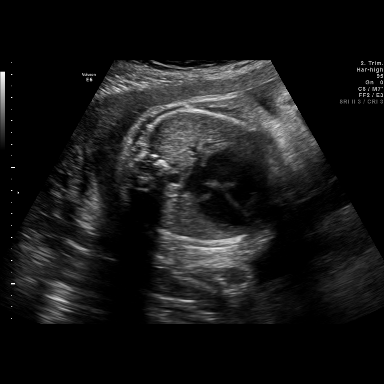


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


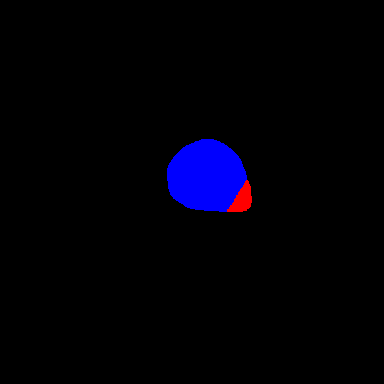


Displaying: Overlay


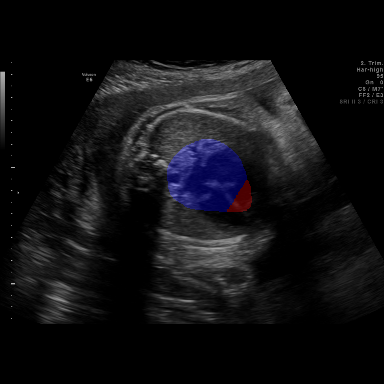


Stats: Cardiac Area = 442 px, Thorax Area = 4446 px


In [14]:

# Suppress warnings
warnings.filterwarnings("ignore")

# --- 2. Define Paths ---
DRIVE_PATH = "/content/drive/My Drive/"
LOCAL_DATA_PATH = "/content/Hackathon Dataset/"
TARGET_IMG_SIZE = (384, 384)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 3. Model Path ---
SEG_MODEL_PATH = os.path.join(
    DRIVE_PATH,
    "hackathon_submission/task_1_segmentation/Model Weights/best_model_hypothesis_2.pth"
)

# --- 4. Re-define Model Architecture ---
print("Defining model architecture (Attention U-Net + EfficientNet-B4)...")
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    in_channels=1,
    classes=3,
    decoder_attention_type='scse'
).to(DEVICE)

# --- 5. Load Saved Model Weights ---
print(f"Loading model from {SEG_MODEL_PATH}...")
try:
    model.load_state_dict(torch.load(SEG_MODEL_PATH, map_location=DEVICE))
    model.eval() # Set to evaluation mode
    print("Model loaded successfully.")
except Exception as e:
    print(f"--- FATAL ERROR: Could not load model. {e} ---")
    raise e

# --- 6. (FIX) Re-define the Helper Function ---
# This ensures we are using the correct version that returns one image
def letterbox_image(image, target_size=(384, 384)):
    """Pads a single image to the target size."""
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    bottom = target_size[0] - new_h - top
    right = target_size[1] - new_w - left

    padded_image = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )
    return padded_image

# --- 7. Load a Test Image and Run ---
print("Loading a test image...")
try:
    TEST_IMG_DIR = os.path.join(LOCAL_DATA_PATH, "Images/testing/images")
    test_image_paths = glob.glob(os.path.join(TEST_IMG_DIR, "*.png"))

    if not test_image_paths:
        print(f"ERROR: No test images found in {TEST_IMG_DIR}")
    else:
        img_path = np.random.choice(test_image_paths)
        print(f"Using test image: {img_path}")

        image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image_gray is None:
            raise IOError(f"Could not read image: {img_path}")

        # --- 8. Preprocess the Image ---
        # This call now uses the correct function defined in Step 6
        padded_gray = letterbox_image(image_gray, TARGET_IMG_SIZE)

        # This line will now work
        tensor_image = torch.from_numpy(padded_gray).float().unsqueeze(0).unsqueeze(0)
        tensor_image = (tensor_image / 255.0).to(DEVICE)

        # --- 9. Run Model Prediction ---
        print("Running prediction...")
        with torch.no_grad():
            logits = model(tensor_image)
            pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy().astype(np.uint8)

        # --- 10. Create Color Visualization ---
        print("\n--- Model Output Visualization ---")

        color_mask = np.zeros((*TARGET_IMG_SIZE, 3), dtype=np.uint8)
        color_mask[pred_mask == 1] = (0, 0, 255) # Cardiac = RED
        color_mask[pred_mask == 2] = (255, 0, 0) # Thorax = BLUE

        padded_bgr = cv2.cvtColor(padded_gray, cv2.COLOR_GRAY2BGR)
        overlay = cv2.addWeighted(padded_bgr, 0.7, color_mask, 0.3, 0)

        # --- 11. Display Results ---
        print("Displaying: Original Padded Image")
        cv2_imshow(padded_bgr)
        print("\nDisplaying: Predicted Mask (Red=Cardiac, Blue=Thorax)")
        cv2_imshow(color_mask)
        print("\nDisplaying: Overlay")
        cv2_imshow(overlay)

        cardiac_area = np.sum(pred_mask == 1)
        thorax_area = np.sum(pred_mask == 2)
        print(f"\nStats: Cardiac Area = {cardiac_area} px, Thorax Area = {thorax_area} px")

except Exception as e:
    print(f"An error occurred: {e}")

Defining model architecture (Attention U-Net + EfficientNet-B4)...
Loading model from /content/drive/My Drive/hackathon_submission/task_1_segmentation/Model Weights/best_model_hypothesis_2.pth...
Model loaded successfully.

--- Starting Test on 10 Random Images ---

--- Test Image 1 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/004.png
Displaying: Original Padded Image


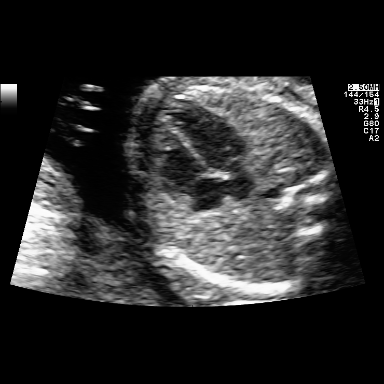


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


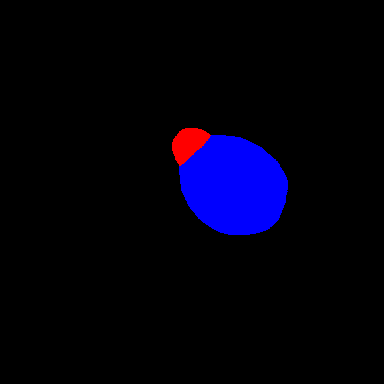

Stats: Cardiac Area = 889 px, Thorax Area = 8252 px
-----------------------------------

--- Test Image 2 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/044.png
Displaying: Original Padded Image


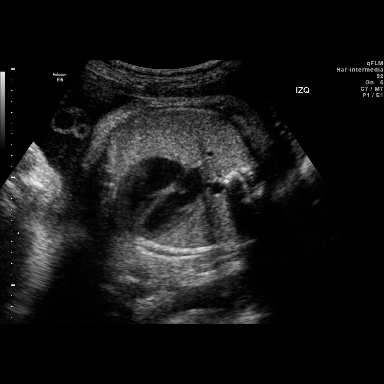


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


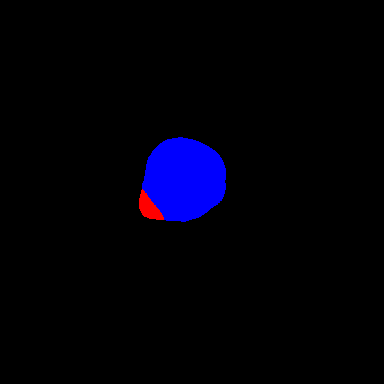

Stats: Cardiac Area = 410 px, Thorax Area = 5434 px
-----------------------------------

--- Test Image 3 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/030.png
Displaying: Original Padded Image


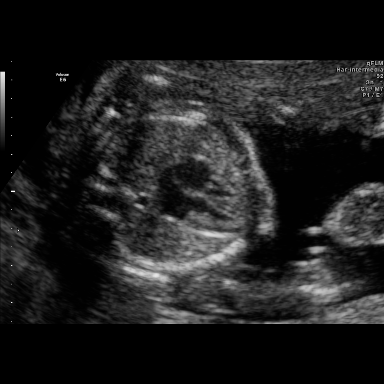


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


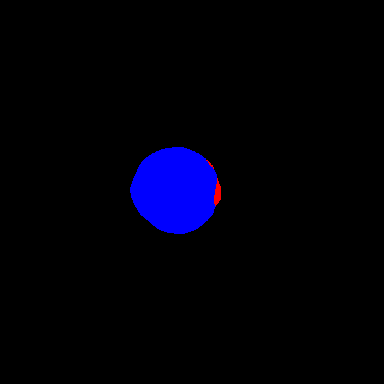

Stats: Cardiac Area = 142 px, Thorax Area = 5851 px
-----------------------------------

--- Test Image 4 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/001.png
Displaying: Original Padded Image


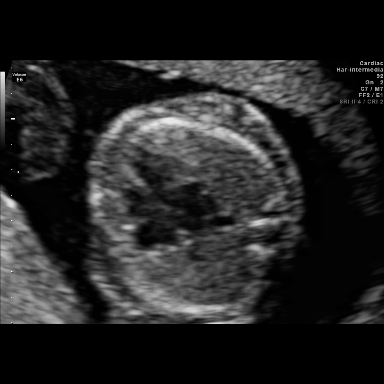


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


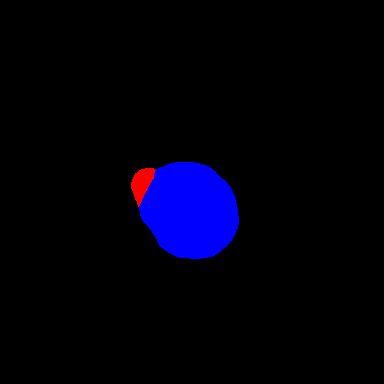

Stats: Cardiac Area = 532 px, Thorax Area = 7397 px
-----------------------------------

--- Test Image 5 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/047.png
Displaying: Original Padded Image


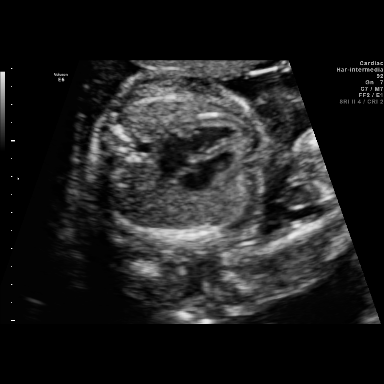


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


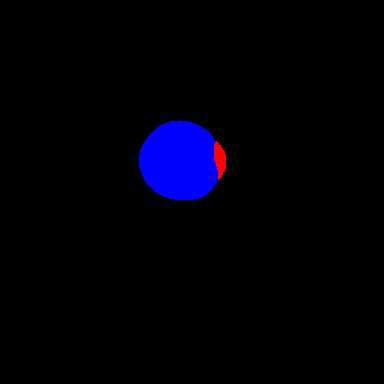

Stats: Cardiac Area = 311 px, Thorax Area = 5042 px
-----------------------------------

--- Test Image 6 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/022.png
Displaying: Original Padded Image


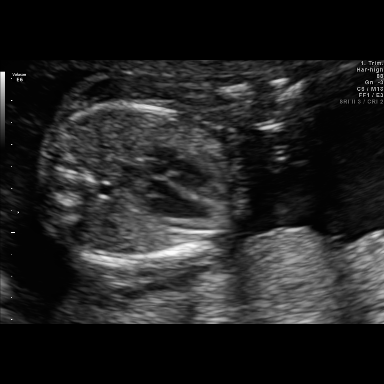


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


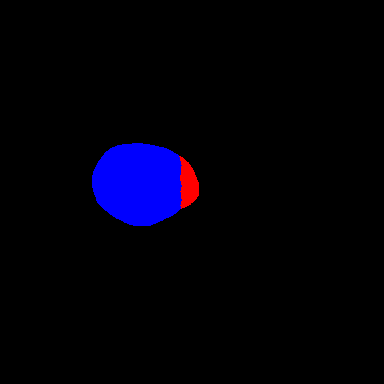

Stats: Cardiac Area = 683 px, Thorax Area = 6112 px
-----------------------------------

--- Test Image 7 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/026.png
Displaying: Original Padded Image


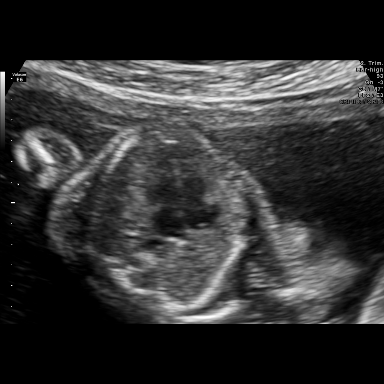


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


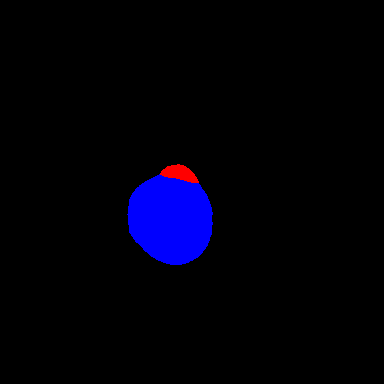

Stats: Cardiac Area = 435 px, Thorax Area = 6014 px
-----------------------------------

--- Test Image 8 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/043.png
Displaying: Original Padded Image


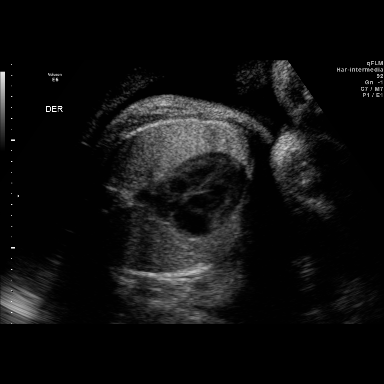


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


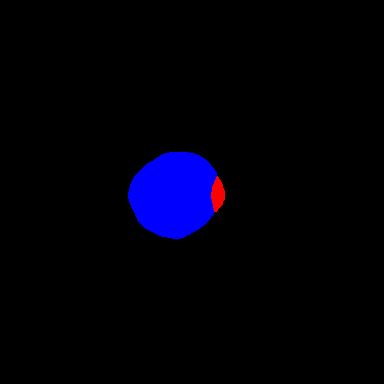

Stats: Cardiac Area = 340 px, Thorax Area = 5928 px
-----------------------------------

--- Test Image 9 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/012.png
Displaying: Original Padded Image


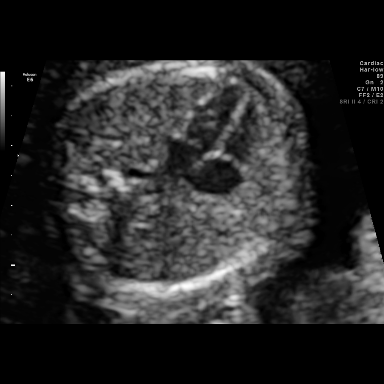


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


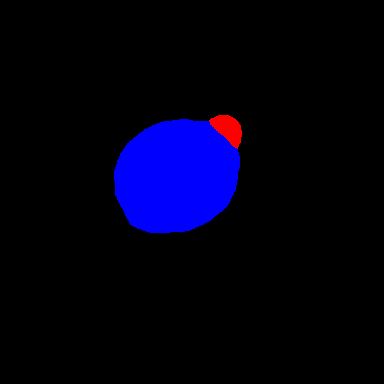

Stats: Cardiac Area = 647 px, Thorax Area = 11320 px
-----------------------------------

--- Test Image 10 of 10 ---
Using test image: /content/Hackathon Dataset/Images/testing/images/032.png
Displaying: Original Padded Image


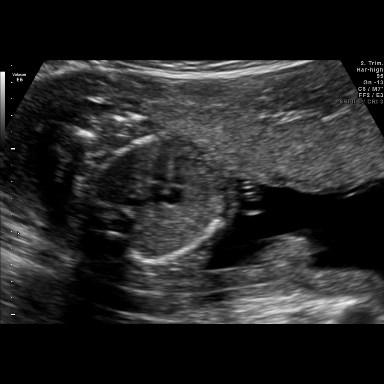


Displaying: Predicted Mask (Red=Cardiac, Blue=Thorax)


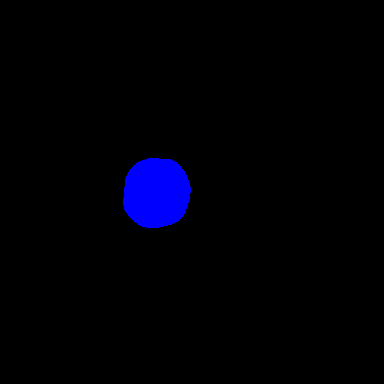

Stats: Cardiac Area = 0 px, Thorax Area = 3857 px
-----------------------------------


In [17]:


DRIVE_PATH = "/content/drive/My Drive/"
LOCAL_DATA_PATH = "/content/Hackathon Dataset/"
TARGET_IMG_SIZE = (384, 384)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 3. Model Path ---
SEG_MODEL_PATH = os.path.join(
    DRIVE_PATH,
    "hackathon_submission/task_1_segmentation/Model Weights/best_model_hypothesis_2.pth"
)

# --- 4. Re-define Model Architecture ---
print("Defining model architecture (Attention U-Net + EfficientNet-B4)...")
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    in_channels=1,
    classes=3,
    decoder_attention_type='scse'
).to(DEVICE)

# --- 5. Load Saved Model Weights ---
print(f"Loading model from {SEG_MODEL_PATH}...")
try:
    model.load_state_dict(torch.load(SEG_MODEL_PATH, map_location=DEVICE))
    model.eval() # Set to evaluation mode
    print("Model loaded successfully.")
except Exception as e:
    print(f"--- FATAL ERROR: Could not load model. {e} ---")
    raise e

# --- 6. Re-define the Helper Function ---
def letterbox_image(image, target_size=(384, 384)):
    """Pads a single image to the target size."""
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    bottom = (target_size[0] - new_h) - top
    right = target_size[1] - new_w - left

    padded_image = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )
    return padded_image

# --- 7. Load 10 Test Images and Run ---
print("\n--- Starting Test on 10 Random Images ---")
try:
    TEST_IMG_DIR = os.path.join(LOCAL_DATA_PATH, "Images/testing/images")
    all_test_image_paths = glob.glob(os.path.join(TEST_IMG_DIR, "*.png"))

    if not all_test_image_paths:
        print(f"ERROR: No test images found in {TEST_IMG_DIR}")
    else:
        # Get 10 random images, or all if less than 10
        num_to_test = min(len(all_test_image_paths), 10)
        test_image_paths = np.random.choice(all_test_image_paths, num_to_test, replace=False)

        # --- Loop over the 10 images ---
        for i, img_path in enumerate(test_image_paths):
            print(f"\n--- Test Image {i+1} of {num_to_test} ---")
            print(f"Using test image: {img_path}")

            image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image_gray is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                continue

            # Preprocess
            padded_gray = letterbox_image(image_gray, TARGET_IMG_SIZE)
            tensor_image = torch.from_numpy(padded_gray).float().unsqueeze(0).unsqueeze(0)
            tensor_image = (tensor_image / 255.0).to(DEVICE)

            # Predict
            with torch.no_grad():
                logits = model(tensor_image)
                pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy().astype(np.uint8)

            # Create Color Visualization
            color_mask = np.zeros((*TARGET_IMG_SIZE, 3), dtype=np.uint8)
            color_mask[pred_mask == 1] = (0, 0, 255) # Cardiac = RED
            color_mask[pred_mask == 2] = (255, 0, 0) # Thorax = BLUE

            padded_bgr = cv2.cvtColor(padded_gray, cv2.COLOR_GRAY2BGR)
            overlay = cv2.addWeighted(padded_bgr, 0.7, color_mask, 0.3, 0)

            # Display Results
            print("Displaying: Original Padded Image")
            cv2_imshow(padded_bgr)
            print("\nDisplaying: Predicted Mask (Red=Cardiac, Blue=Thorax)")
            cv2_imshow(color_mask)

            # Print stats for this image
            cardiac_area = np.sum(pred_mask == 1)
            thorax_area = np.sum(pred_mask == 2)
            print(f"Stats: Cardiac Area = {cardiac_area} px, Thorax Area = {thorax_area} px")
            print("-----------------------------------")

except Exception as e:
    print(f"An error occurred: {e}")